# Notebook for testing how distortions change in Normalizing Flows

In [1]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

import umap
reducer = umap.UMAP();
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/v

Using device cuda:0


In [2]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
from NF_utils import Latent_data, create_latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay
from GAN_utils import GAN_Input

Using device cuda:0


In [3]:
from numpy.random import default_rng
rng = default_rng()


In [4]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"


In [5]:
num_samples = 100
MC_Graphs = GraphDataset(prefix+MCdataset)

#pid dictionary:
pid_dict = {
    0 : "photon",
    1 : "electron",
    -1 : "positron",
    0.8 : "proton",
    -0.8 : "anti-proton",
    0.5 : "neutron",
    -0.5 : "anti-neutron",
    0.1 : "pi0",
    0.6 : "pi+",
    -0.6 : "pi-",
    0.3 : "K0",
    0.4 : "K+",
    -0.4 : "K-"
}

In [57]:
inputs = GAN_Input(MC_Graphs, distortion_range = (-0.02,0.02))

In [58]:
# SETTING UP DATA MODEL

masked_affine_flows_train_distort = get_masked_affine(latent_dim = 6)
distribution_distort = nf.distributions.DiagGaussian(inputs.num_features, trainable = False)
masked_affine_model_distort = nf.NormalizingFlow(q0=distribution_distort, flows=masked_affine_flows_train_distort)
distort_model = masked_affine_model_distort.to(device)

In [59]:
# SETTING UP MC MODEL

masked_affine_flows_train_MC = get_masked_affine(latent_dim = 6)
distribution_MC = nf.distributions.DiagGaussian(inputs.num_features, trainable = False)
masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
MC_model = masked_affine_model_MC.to(device)

  0%|          | 0/1411 [01:32<?, ?it/s]


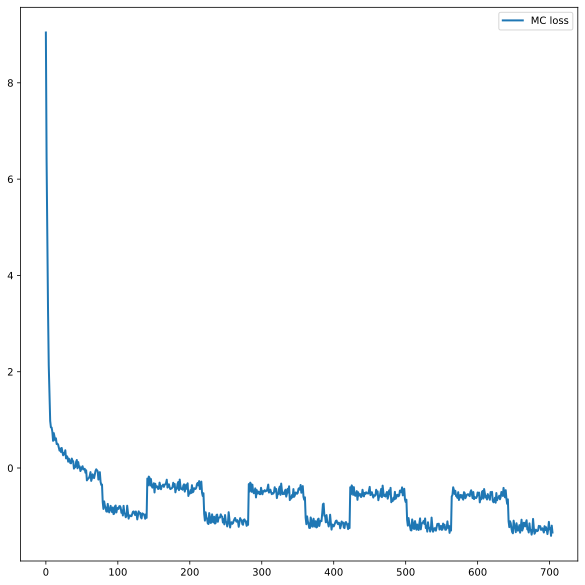

Lowest Loss: -1.408998054265976


In [60]:
# TRAINING MC
loss_hist = train(inputs, MC_model, distorted = False, num_epochs = 5,compact_num = 10)
plot_loss(loss_hist[0], label = "MC loss")

  0%|          | 0/1411 [01:31<?, ?it/s]


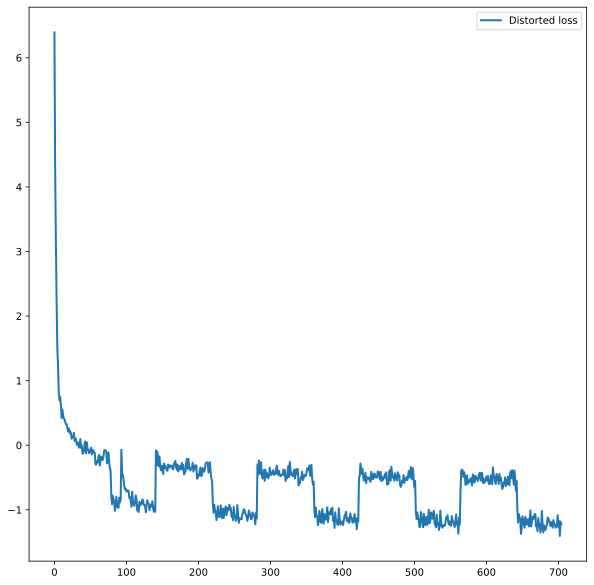

Lowest Loss: -1.4052165806293488


In [61]:
# TRAINING Distorted
loss_hist = train(inputs, distort_model, distorted = True, num_epochs = 5, compact_num = 10)
plot_loss(loss_hist[0], label = "Distorted loss")

# Testing MC and DATA models

In [62]:
#Testing dataset for DATA: testing_data_DATA
#Testing dataset for MC: testing_data_MC

In [63]:
# Testing MC
test(inputs, MC_model, data_type = "MC")
# Testing DATA
test(inputs, distort_model, data_type = "MC distorted", distorted = True)

100%|██████████| 1411/1411 [00:20<00:00, 68.66it/s]


MC average loss: -0.8069549798965454


100%|██████████| 1411/1411 [00:20<00:00, 69.97it/s]

MC distorted average loss: -0.7497181296348572


# Plotting sanity checks

In [64]:
class GAN_Input():
    def __init__(self, GraphDataset, num_features = 6, batch_size = 100, distortion_range = (-1,1), distort = True):
        self.GraphDataset = GraphDataset
        self.num_features = num_features
        self.batch_size = batch_size
        self.num_events = len(self.GraphDataset.graphs)
        self.max_iter = int(self.num_events / self.batch_size)
        self.data = torch.zeros(self.num_events,self.num_features)
        self.create_data_tensor()
        if(distort):
            self.distort(distortion_range = distortion_range)
    def set_batch_size(self,batch_size):
        self.batch_size = batch_size
        self.num_events = len(self.GraphDataset.graphs)
    def create_data_tensor(self):
        for i in range(self.num_events):
            event = self.GraphDataset.graphs[i].ndata['data']
            found_proton = False
            found_pion = False
            #loop over each particle in graph
            for j in range(event.size()[0]):
                particle = event[j]
                #catch protons
                if particle[5] == 0.8:
                    for k in range(3):
                        self.data[i][k] = particle[k]
                    found_proton = True

                #catch pi-
                elif particle[5] == -0.6:
                    for k in range(3):
                        self.data[i][k + 3] = particle[k]
                    found_pion = True

                #stop looking after lambda products found
                if(found_proton and found_pion):
                    break
        self.MC_min = self.data.min()
        self.MC_max = self.data.max()
    def distort(self, index = 0, distortion_range = (-1,1)):
        #Grab random numbers
        distortions = torch.rand(self.data.shape[0],self.data.shape[1])
#         #make distortions between -1 and 1
#         distortions = (distortions * (-2)) + 1
        #Trying to make distortions between -0.2 and 0.2 now
        distortions = (distortions * (distortion_range[0] - distortion_range[1])) + distortion_range[1]
        #Keep only numbers in the proton pT index
        distortions[:,1:] = 0
        self.distorted_features = torch.clone(self.data) + distortions
        self.distort_min = self.distorted_features.min()
        self.distort_max = self.distorted_features.max()
    def normalize(self, distorted = False):
        if(distorted):
            data = torch.clone(self.distorted_features)
        else:
            data = torch.clone(self.data)
        input_max = data.max()
        input_min = data.min()
        if(distorted):
            self.distorted_features = (data - input_min) / (input_max - input_min)
        else:
            self.data = (data - input_min) / (input_max - input_min)
#     def unnormalize(self, distored = False):
    def sample(self,iteration = 0, distorted = False):
        #0 index iterations - the "first" iteration is with iteration = 0
        # Calculate the first index we want to take from training data (rest of data is directly after)
        begin = iteration * self.batch_size
        # initialize
        samples = torch.zeros(self.batch_size, self.num_features)
        #loop over consecutive tensors, save to return tensor
        if distorted:
            for i in range(self.batch_size):
                samples[i] = self.distorted_features[begin + i]
        else:
            for i in range(self.batch_size):
                samples[i] = self.data[begin + i]
        return samples

In [66]:
normalized_MC = transform(inputs, MC_model)
normalized_distorted = transform(inputs, distort_model, distorted = True)

100%|██████████| 1411/1411 [00:20<00:00, 70.19it/s]


In [67]:
normalized_distorted_obj = Latent_data(normalized_distorted, torch.empty([]))
full_pass_distorted = transform(inputs, MC_model, reverse = False)

100%|██████████| 1411/1411 [00:19<00:00, 72.05it/s]


In [68]:
def plot_6_histos(data_tensor, color,bins = 150, description = "none", save = False, save_loc = "plots/img.jpeg"):
    histos, ((h11,h12,h13),(h21,h22,h23)) = plt.subplots(2,3, figsize = (10,7))
    if description == "none":
        histos.suptitle("Several 1D Histos")
    else:
        histos.suptitle(f"Several 1D Histos {description}")
    hlist = [h11,h12,h13,h21,h22,h23]
    for i in range(len(hlist)):
        hlist[i].hist(data_tensor[:,i], bins=150,color=color, density = True);
        hlist[i].set_xlim([-1,1])
    plt.show()
    if(save):
        histos.savefig(save_loc)

In [69]:
distortions = torch.rand(inputs.data.shape[0],inputs.data.shape[1])
distortions = (distortions * -(0.02 + 0.2)) + 0.02
adjusted = torch.clone(inputs.data) + distortions

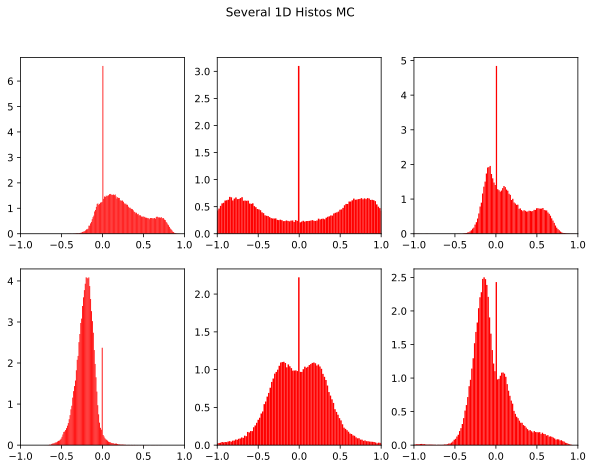

In [70]:
plot_6_histos(inputs.data,'r', description = "MC", save = True, save_loc = "plots/NF/six_hists_MC.jpeg")

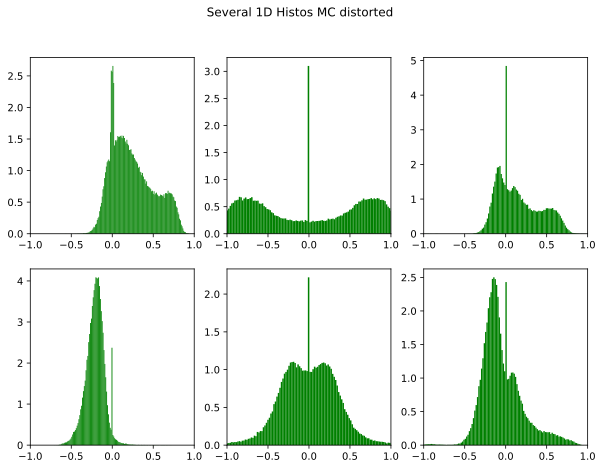

In [71]:
plot_6_histos(inputs.distorted_features,'g', description = "MC distorted", save = True, save_loc = "plots/NF/six_hists_MC_distort_0_02.jpeg")

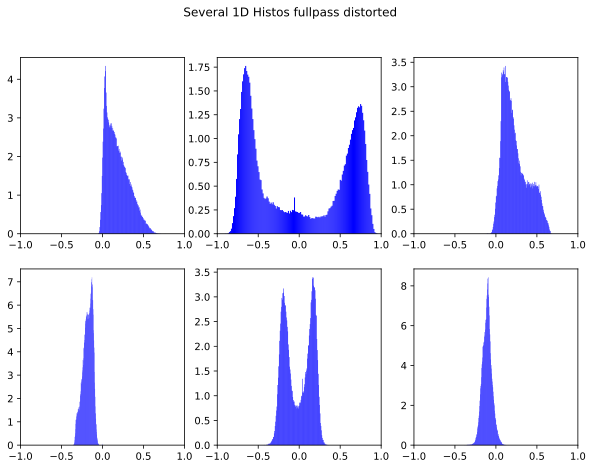

In [72]:
plot_6_histos(full_pass_distorted,'b', description = 'fullpass distorted', save = True, save_loc = "plots/NF/six_hists_fullpass_0_02.jpeg")